In [12]:
import polyglot
from polyglot.text import Text
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io
import requests
import itertools
from functions import *
from glob import glob as gb
from tqdm import tqdm
from nltk.corpus import sentiwordnet as swn

from nrclex import NRCLex
plotting.style_('viridis',12)


In [13]:
base_path = "/home/ruben/Documents/GitHub/ParlaMintCase"

In [15]:
def chen_classifier(text,language):
    try:
        text = text.split(' ')
        pos_words = set(pd.read_csv(base_path + f'/resources/lexicons/sentiment-lexicons/positive_words_{language}.txt',header=None)[0])
        neg_words = set(pd.read_csv(base_path + f'/resources/lexicons/sentiment-lexicons/negative_words_{language}.txt',header=None)[0])
        s =0
        for w in text:
            if w in pos_words or w in neg_words:
                s += 1
        return s / len(text)
    except Exception as e:
        return float("nan")

def polyglot_classifier(text):
    try:
        text = Text(text)
        r = sum([w.polarity for w in text.words]) / len(text.words)
        return r
    except Exception as e:
        return float("nan")

def sentistrength_classifier(text,language):
    try:
        text = text.split(' ')
        def grouper(n, iterable, fillvalue=None):
            args = [iter(iterable)] * n
            return itertools.zip_longest(*args, fillvalue=fillvalue)

        try:
            with open(base_path + f'/resources/lexicons/sentistrength-lexicons/{language}.txt','r',encoding="utf-8") as f:
                c = [x.replace('\n','').split('\t') for x in f.readlines()]
        except Exception:
            with open(base_path + f'/resources/lexicons/sentistrength-lexicons/{language}.txt','r',encoding='latin-1') as f:
                c = [x.replace('\n','').split('\t') for x in f.readlines()]

        d = [list(grouper(2,x)) for x in c]
        d = [item for sublist in d for item in sublist]
        d = {x[0].replace(u'\xa0', u' ').replace(' ','').lower():int(x[1]) for x in d}
        r = [d[w] if w in d.keys() else 0 for w in text]
        return sum(r) / len(r)
    except Exception as e:
        return float("nan")

In [16]:
def prepare(language,data_version="lemmatized",metadata=''):
    # additional metadata = list of tuples [('column_name','value)]
    data = data_loader.period(language=language,data_version="lemmatized",start_date="2019-10",end_date="2020-06")
    data['date'] = [utils.find_date(x) for x in data['id']]
    data = utils.add_metadata(data,language)
    data['text'] = utils.preprocess_(data['text'])
    if metadata != '':
        for x in metadata:
            data = data[(data[metadata[0]].str.contains(metadata[1]))].reset_index(drop=True)
    data = data[data.text.str.split(' ').str.len() >= 100].reset_index(drop=True)
    data = data["id text date speaker_party".split(' ')]
    print('starting polarity measurement')
    data['c1'] = [chen_classifier(x,language) for x in tqdm(data['text'])]
    data['c2'] = [polyglot_classifier(x) for x in tqdm(data['text'])]
    
    try:
        data['c3'] = [sentistrength_classifier(x) for x in tqdm(data['text'])]
    except:
        print('no support for sentistrength')
        
    start_dates_for_labels = [y + '-01' for y in list(set([x[:7] for x in data.date]))]
    new = pd.DataFrame([[None,None,d,None,None,None] for d in start_dates_for_labels],columns = data.columns)
    data = data.append(new)
    data = data.sort_values('date').reset_index(drop=True)
    return data

In [17]:
def plot_(data,cl,title,language,save=False):
    fig, ax = plt.subplots(figsize=(22,5))
    # sns.stripplot(x="date", y=cl, data=data,jitter=0.2,alpha=.2,color='teal',size=5)
    plt.scatter(x=data['date'],y=data[cl],c='teal',alpha=.1)
    # lbs = [item.get_text() for item in p.get_xticklabels()]
    # new_lbs = [x if x.split('-')[2] == "01" else "" for x in lbs]
    # 
    nlbs = []
    for c,t in enumerate(sorted(list(set(data.date)))):
        if "01-01" in t or "03-01" in t or "05-01" in t or "07-01" in t or "09-01" in t or "11-01" in t:
            nlbs.append(t)
        else:
            nlbs.append('')
    ax.set_xticklabels(nlbs)

    avgs = pd.DataFrame([[m,data[data['date'] == m][cl].sum() / len(data[data['date'] == m])] for m in set(data['date'])],columns=['date',cl]).sort_values('date')
    rm = avgs[cl].rolling(4, win_type='gaussian').mean(std=3)
    plt.plot(avgs['date'],rm)
    plt.title(title,fontsize=16)
    if save == True:
        plt.savefig(base_path + f"/results/plots/polarity/{language}-{cl}.png",bbox_inches='tight',dpi=250)
    plt.show()
    return 

looking for data in  /media/ruben/Elements/ParlaMint/it/it-ana-txt/
found 72 files
  0%|          | 0/2308 [00:00<?, ?it/s]
no support for sentistrength


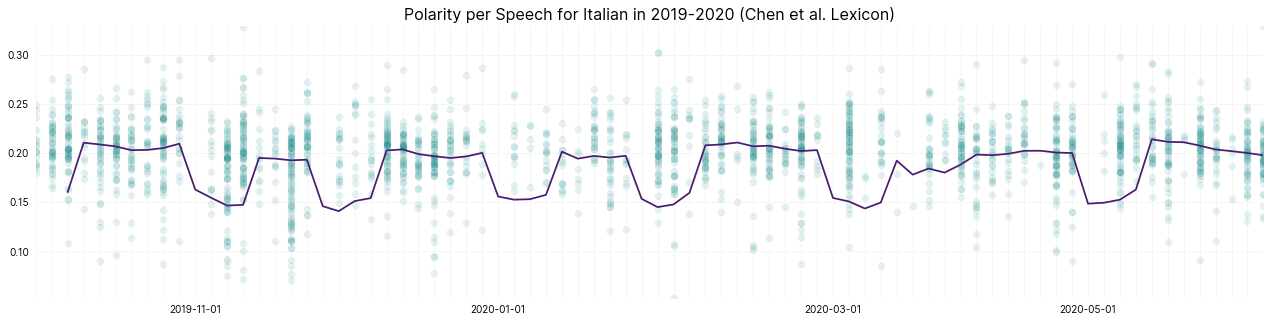

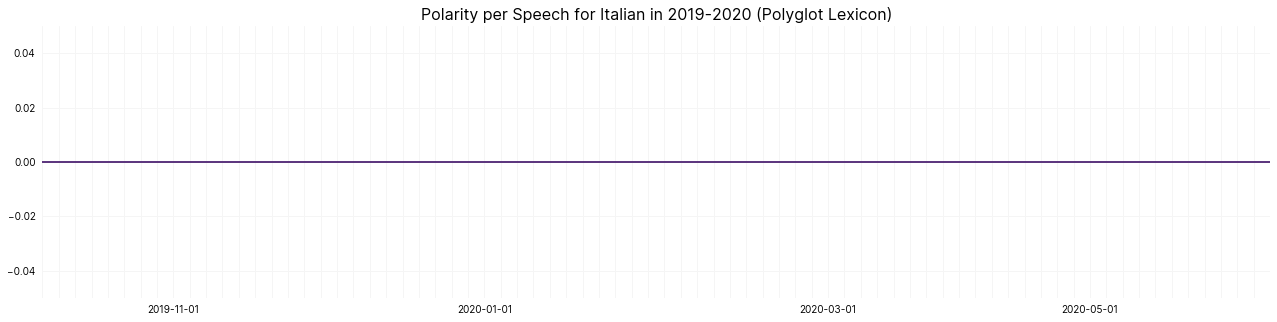

KeyError: 'c3'

In [21]:
language_dict = {"pl":"Polish","bg":"Bulgarian","si":"Slovenian","nl":"Dutch","gb":"British","it":"Italian"}

for l in ["it","nl","pl","bg","si"]:
    data = prepare(l)
    plot_(data,'c1',f'Polarity per Speech for {language_dict[l]} in 2019-2020 (Chen et al. Lexicon)',l,save=True)
    plot_(data,'c2',f'Polarity per Speech for {language_dict[l]} in 2019-2020 (Polyglot Lexicon)',l,save=True)
    plot_(data,'c3',f'Polarity per Speech for {language_dict[l]} in 2019-2020 (SentiStrength Lexicon)',l,save=True)
    break

In [20]:
data

,id,text,date,speaker_party,c1,c2
0,ParlaMint-GB_2019-10-01-commons.u285,every death of a homeless person be a preventa...,2019-10-01,SNP,NaN,NaN
1,ParlaMint-GB_2019-10-01-commons.u371,we remain deeply concerned about report of civ...,2019-10-01,CON,NaN,NaN
2,ParlaMint-GB_2019-10-01-commons.u363,the hon gentleman mention the uk contribution ...,2019-10-01,CON,NaN,NaN
3,ParlaMint-GB_2019-10-01-commons.u362,i too thank the chair of the international dev...,2019-10-01,SNP,NaN,NaN
4,ParlaMint-GB_2019-10-01-commons.u361,we ae work closely with the us as a member of ...,2019-10-01,CON,NaN,NaN
...,...,...,...,...,...,...
17588,ParlaMint-GB_2020-05-21-lords.u130,my lords we recognise that the health of the p...,2020-05-21,LD;NA,NaN,NaN
17589,ParlaMint-GB_2020-05-21-lords.u129,my lords i thank the noble lord lord dobbs for...,2020-05-21,LAB,NaN,NaN
17590,ParlaMint-GB_2020-05-21-lords.u128,my lords today i would like to talk about how ...,2020-05-21,CON,NaN,NaN
17591,ParlaMint-GB_2020-05-21-lords.u142,my lords i thank the noble lord lord dobbs for...,2020-05-21,NaN,NaN,NaN


In [ ]:
# Plot With Dots colored / party
# fig,ax = plt.subplots(figsize=(20,10))
# colors = {k:sns.color_palette('Paired',12)[c] for c,k in enumerate(list(set(data['speaker_party'])))}
# plt.scatter(data['date'], data['c1'],c=data['speaker_party'].map(colors),alpha=0.3,s=35)
# for label in ax.get_xticklabels():
#     label.set_rotation(90) 
# # plt.ylim(0,0.8)

In [5]:
def get_data(language):
    data = data_loader.period(language=language,data_version="lemmatized",start_date="2019-06",end_date="2020-06")
    data = data[data["text"].str.len() >= 500]
    data['date'] = [utils.find_date(x) for x in data['id']]
    data = data.dropna().reset_index(drop=True)

In [6]:
d = get_data('nl')

looking for data in  /media/ruben/Elements/ParlaMint/nl/nl-ana-txt/
found 796 files
